In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
## metadata = MetaData(engine, reflect=True)
## measure_table = metadata.tables['measurement']
## station_table = metadata.tables['station']
## Measurement.metadata.tables
## Station.metadata.tables
## first_row = session.query(Measurement).first()
## first_row = session.query(Station).first()

# Exploratory Climate Analysis

In [12]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

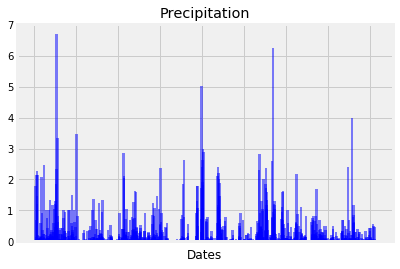

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# date 1 week ago from today
start_date = dt.datetime.strptime(str(latest_date[0]), "%Y-%m-%d") - dt.timedelta(days=366)
## this line not work: one_year_ago = [(latest_date)] - dt.timedelta(days=365)
## print(start_date)

# Perform a query to retrieve the data and precipitation scores
history_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > start_date).filter(Measurement.date <= 'latest_date').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_history_precipitation = pd.DataFrame(history_precipitation)


## df_history_precipitation = df_history_precipitation.sort_values(by='date', ascending=True)
df_history_precipitation = df_history_precipitation.sort_values(by='date', ascending=True)
df_history_precipitation = df_history_precipitation.set_index("date")

# Sort the dataframe by date
data = df_history_precipitation
df_data = data.sort_values(by='date', ascending=True)

# Drop column with "NaN"
df_data = data.dropna(subset=['prcp'])
## df_data.head()

# Use Pandas Plotting with Matplotlib to plot the data
# Define labels
plt.title("Precipitation")
plt.xlabel("Dates")
plt.ylabel("")

# Define X and Y values
y = df_data["prcp"].tolist()
x = np.arange(len(df_data))

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])

# Define plot
plt.bar(x, y, width=15, color="blue", alpha=0.5, align="edge")
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

# Display a statistical overview of the DataFrame
df_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"Total number of stations: {(stations_available)}")

Total number of stations: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
## most_active_stations = session.query(Measurement.station).group_by(Measurement.station).max()

active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

print(f"The most active station is: {active_stations[0][0]}\n")
print(f"List of Station Activities from Most Active to Least Active: ")
df_active_stations = pd.DataFrame(active_stations, columns=['Station ID', 'Activity Count'])
df_active_stations

The most active station is: USC00519281

List of Station Activities from Most Active to Least Active: 


,Station ID,Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

## From Billy
most_active_station = active_stations[0][0]

most_active_station_temps = session.query(
        Measurement.station.label('Station ID'),
        func.min(Measurement.tobs).label('Max Temp'), 
        func.max(Measurement.tobs).label('Min Temp'), 
        func.avg(Measurement.tobs).label('Avg Temp')).\
        filter(Measurement.station == most_active_station).all()

print(f"Most Active Station Tempreture Stats:")
df_temp_stat = pd.DataFrame(most_active_station_temps).set_index('Station ID').transpose()
df_temp_stat

Most Active Station Tempreture Stats:


Station ID,USC00519281
Max Temp,54.000000
Min Temp,85.000000
Avg Temp,71.663781


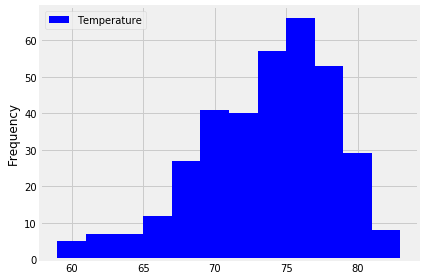

<Figure size 432x288 with 0 Axes>

In [51]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogra = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= start_date).all()
high_temp = session.query(Measurement.station,Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= start_date).all()
df = pd.DataFrame(high_temp, columns=['Station', 'Temperature'])

df.plot.hist(bins=12, color='blue')
plt.tight_layout()
plt.show()
plt.savefig('station_temp.png')

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
## TMIN, TAVG, and TMAX for a list of dates.
    
##    Args:
##        start_date (string): A date string in the format %Y-%m-%d
##        end_date (string): A date string in the format %Y-%m-%d
        
    min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.date > start_date)\
                             .filter(Measurement.date < end_date).all()
    max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.date > start_date)\
                             .filter(Measurement.date < end_date).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date > start_date)\
                             .filter(Measurement.date < end_date).all()
        
##    Returns:
##        TMIN, TAVE, and TMAX

    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2011-02-28', '2011-03-05')

df_my_trip = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])
df_my_trip

62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


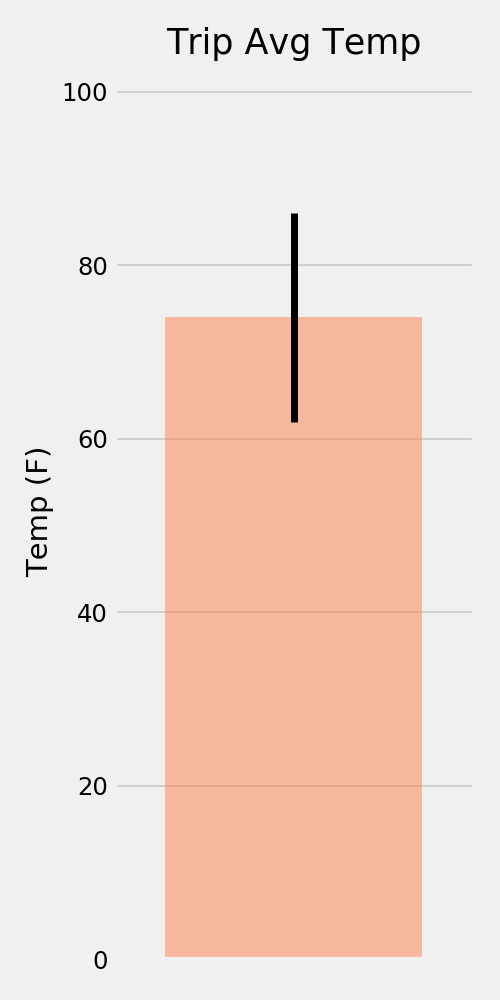

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def percipitation(start_date, end_date):
    
    sel = [
        Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        Measurement.prcp
    ]
    
    return session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

df_my_trip_prcp = pd.DataFrame(percipitation('2016-08-24', '2017-08-23'))

df_my_trip_prcp


,station,name,latitude,longitude,elevation,prcp
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.28
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.15
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.15
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.45
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.22
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.08
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


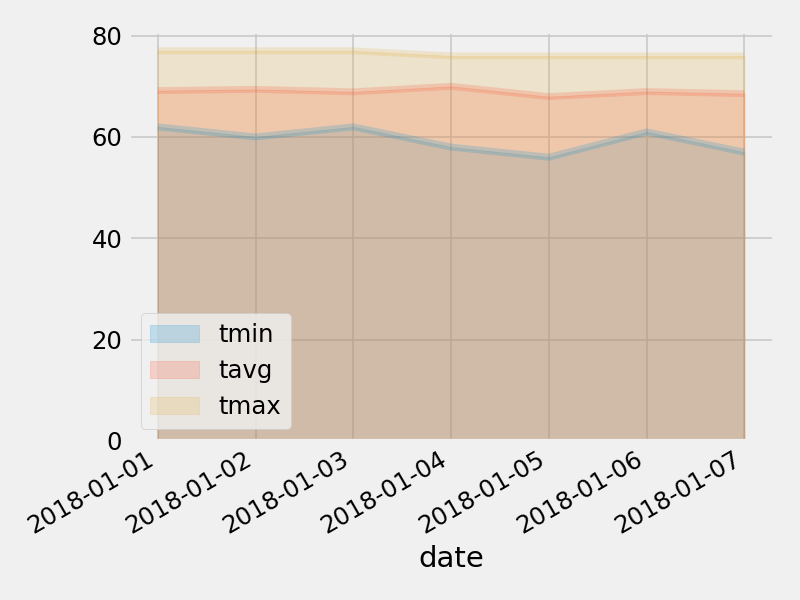

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
